# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

## Import Python Libs

In [1]:
import pandas as pd
import numpy as np
import string

# Load LendingClub dataset

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In [2]:
loans = pd.read_csv('../input_data/classification/lending-club-data.csv')

/home/yoyoams/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `sub_grade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

In [4]:
loans['home_ownership']

0             RENT
1             RENT
2             RENT
3             RENT
4             RENT
5             RENT
6              OWN
7             RENT
8              OWN
9              OWN
10            RENT
11            RENT
12            RENT
13            RENT
14            RENT
15        MORTGAGE
16        MORTGAGE
17            RENT
18            RENT
19             OWN
20            RENT
21            RENT
22        MORTGAGE
23            RENT
24            RENT
25        MORTGAGE
26            RENT
27        MORTGAGE
28        MORTGAGE
29            RENT
            ...   
122577        RENT
122578    MORTGAGE
122579    MORTGAGE
122580        RENT
122581        RENT
122582    MORTGAGE
122583        RENT
122584        RENT
122585         OWN
122586    MORTGAGE
122587    MORTGAGE
122588         OWN
122589    MORTGAGE
122590         OWN
122591    MORTGAGE
122592        RENT
122593    MORTGAGE
122594         OWN
122595    MORTGAGE
122596    MORTGAGE
122597    MORTGAGE
122598    MO

This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

In [5]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

In [9]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
perc_safe=len(safe_loans_raw)/float(len(loans))
perc_risk=len(risky_loans_raw)/float(len(loans))

In [10]:
print ("%.2f" %perc_safe)
print ("%.2f" %perc_risk)

0.81
0.19


You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [11]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)


In [12]:
# Extract the feature columns and target column
loans = loans[features + [target]]

In [13]:
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [14]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print( "Number of safe loans  : %s" % len(safe_loans_raw))
print( "Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [15]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [16]:
print ("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print ("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print ("Total number of loans in our new dataset :", len(loans_data))

('Percentage of safe loans                 :', 0.5)
('Percentage of risky loans                :', 0.5)
('Total number of loans in our new dataset :', 46300)


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [70]:
import json
with open('../input_data/classification/module-5-assignment-1-train-idx.json') as json_data:
    train_idx = json.load(json_data)
with open('../input_data/classification/module-5-assignment-1-validation-idx.json') as json_data:
    validation_idx = json.load(json_data)

In [71]:
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

In [72]:
train_data.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
6,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
7,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
10,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
12,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


In [73]:
#go around pandas intelligent(?) type conversion
train_data.loc[:,'term'] = train_data.loc[:,'term'].astype(str)
validation_data.loc[:,'term'] = validation_data.loc[:,'term'].astype(str)

# One-hot encoding

For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. The next assignment has more details about this.

In [74]:
#1st Find the categorical features
features = train_data.columns.values.tolist()
categorical_variables = []
for feat_name in  features:
    if type(train_data[feat_name].iloc[0]) == str:
        categorical_variables.append(feat_name)
print(categorical_variables)

['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']


In [75]:
#fix for column term
train_data.loc[:,'term'] = train_data.loc[:,'term'].str.replace(' ', '')
validation_data.loc[:,'term'] = validation_data.loc[:,'term'].str.replace(' ', '')

In [76]:
#then encode the values
from sklearn import preprocessing
enc = preprocessing.LabelBinarizer()

for col in categorical_variables:
    # creating an exhaustive list of all possible categorical values
    data=train_data[[col]].append(validation_data[[col]])
    enc.fit(data)
    # Fitting One Hot Encoding on train data
    temp = enc.transform(train_data[[col]])
    #fix for column term
    if col == 'term':
        temp = np.hstack((temp, 1 - temp))
    # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
    # In side by side concatenation index values should be same
    # Setting the index values similar to the train data frame
    temp=temp.set_index(train_data.index.values)
    # adding the new One Hot Encoded varibales to the train data frame
    train_data=pd.concat([train_data,temp],axis=1)
    #drop the original column from the df
    del train_data[col]
    #debug print ('###column###',col) 
    #debug print ('############')
    #debug print(list(train_data_1.columns.values))
    # fitting One Hot Encoding on validation data
    temp = enc.transform(validation_data[[col]])
    #fix for column term
    if col == 'term':
        temp = np.hstack((temp, 1 - temp))
    # changing it into data frame and adding column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in validation_data[col].value_counts().index])
    # Setting the index for proper concatenation
    temp=temp.set_index(validation_data.index.values)
    # adding the new One Hot Encoded varibales to test data frame
    validation_data=pd.concat([validation_data,temp],axis=1)  
    del validation_data[col]

# Use decision tree to build a classifier

Now, let's use the built-in Scikit Create decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above. Use `validation_set=None` to get the same results as everyone else.

In [77]:
y = train_data['safe_loans']
del train_data['safe_loans']
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder

decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(train_data, y)
decision_tree_model.score(train_data, y)

0.64052761659144641

## Visualizing a learned model

Use Graphviz to visualize the decision tree

In [78]:
import graphviz

In [79]:
export_graphviz(decision_tree_model,out_file='decision_tree_model_tree.dot',feature_names=train_data.columns)  
with open("decision_tree_model_tree.dot") as f:
    dot_graph = f.read()

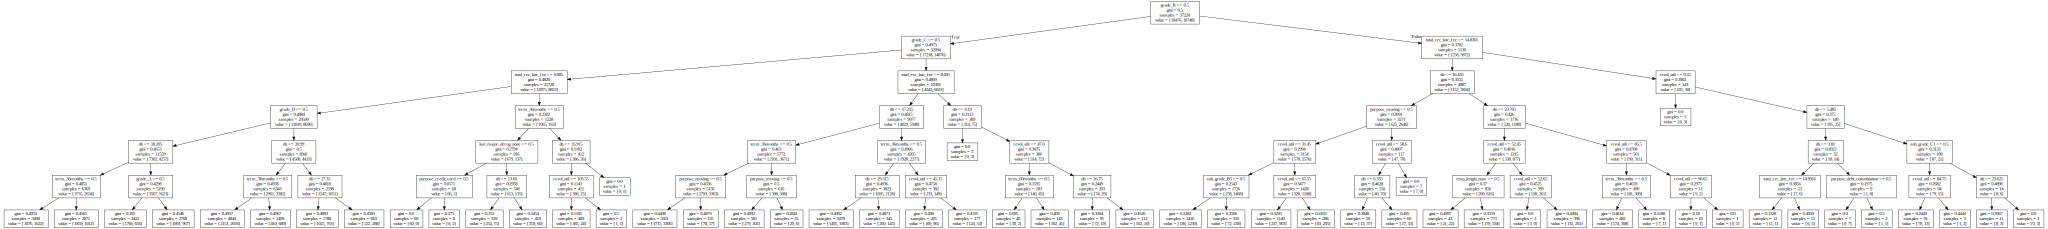

In [80]:
graphviz.Source(dot_graph)

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [82]:
y_val = validation_data['safe_loans']
del validation_data['safe_loans']
print ('train data accuracy',decision_tree_model.score(train_data, y))
print ('validation data accuracy',decision_tree_model.score(validation_data, y_val))

('train data accuracy', 0.64052761659144641)
('validation data accuracy', 0.63614821197759586)
